In [186]:
pip install sklearn-pycrfsuite

In [187]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

# **1. Split the training data into 80% training, 20% development set**

In [188]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [189]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt")

In [190]:
from sklearn.model_selection import train_test_split
training_data_train, training_data_develope = train_test_split(raw_training_data, train_size=0.8, shuffle=False)

In [191]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [192]:
training_data = [preProcess(example) for example in training_data_train]

In [193]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [194]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [195]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
develope_data = [preProcess(example) for example in training_data_develope]
print(len(develope_data), "instances")
print(sum([len(sent) for sent in develope_data]), "words")

1564 instances
31304 words


In [196]:
print("testing tagger...")
preds = []
y_test = []
for sent in develope_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [197]:
print(classification_report(y_test, preds))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.65      0.13      0.22       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.47      0.23      0.30       160
        B-Origin       0.58      0.44      0.50       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.82      0.41      0.55       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.61      0.12      0.20       165
      I-Director       0.86      0.66      0.75       456
         I-Ge

In [198]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    print(cm)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

[[   27     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     1     0     5     0     0     0     0
      0]
 [    0    70     0     5     0     0     1    28     0     0     0     0
      2     0     1     0     2    33     1    11     0     4     0     1
      0]
 [    0     0     4     0     0     0     0     0     0     0     0     0
      1     0     0     0     0    12     0     6     1     0     0     0
      0]
 [    0     0     0   628     4     0     3     4     0    40     1     0
     10     0     8     0     8    58     0    18     0     3     4    16
      0]
 [    0     0     0     0   301     4     1    10     0    14     0     0
      0     1    80     0     3    22     1    17     0     1     1     0
      0]
 [    0     0     0     0     3    20     0    10     0     2     1     0
      1     0    32     0     0     6     0    89     0     0     1     0
      0]
 [    0     0     0     0     0     0    99    11     0   

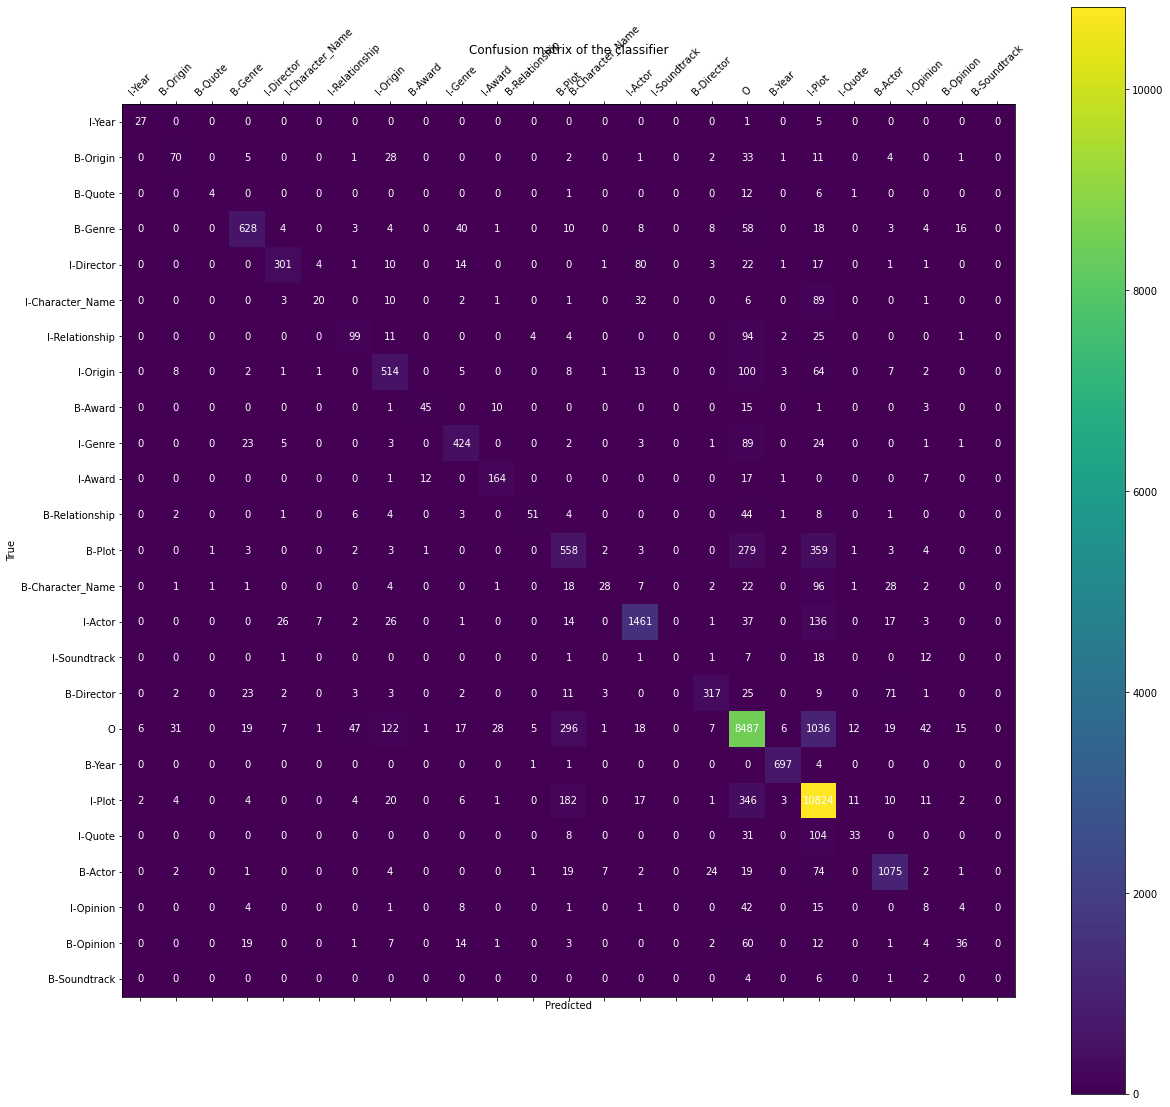

In [199]:
confusion_matrix_heatmap(y_test, preds)

# **2. Error analysis 1: False positives**





In [200]:
print("evaluating tagger...")
preds = []
y_test = []
false_positive_sent = []
false_negative_sent = []

lowest_precision_score = ['B-Opinion', 'B-Plot', 'B-Soundtrack', 'I-Opinion', 'I-Soundtrack'] # 5 classes/labels which have the lowest precision score    

for sent in develope_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    for label in lowest_precision_score:
        for i in range(len(sent_preds)):
            if sent_preds[i] == label and sent_preds[i] != sent_true[i]:
                s = ''
                for t in sent:
                         s += t[0] + ''
                if s not in false_positive_sent:
                    false_positive_sent.append(s) # a false positive for that class
                    print('\r\n',s)
                    print('Misclassified Word:',sent[i][0])
                    print('Predicted:',sent_preds[i])
                    print('Actual:',sent_true[i])

print("done")

evaluating tagger...

 onavacationinparisoneofthreetravelersismistakenforabritishheiress
Misclassified Word: a
Predicted: B-Plot
Actual: I-Plot

 oneofthefirstdisneyanimatedfilmswithbeautifulimagesfewlinesandalotofmusic
Misclassified Word: beautiful
Predicted: B-Plot
Actual: O

 orsonwellesdirectedandstarredinthis1965movieaboutthecareerofshakespearessirjohnfalstaffasroisteringcompaniontoyoungprincehal
Misclassified Word: roistering
Predicted: B-Plot
Actual: I-Plot

 orsonwellspsychologicalprofileofaneccentricbillionairehasbeenvotedthegreatestmovieofalltimebysome
Misclassified Word: psychological
Predicted: B-Plot
Actual: O

 paulgiamattiandthomashadenchurcharetwomenreachingmiddleagewithnotmuchtoshowbutdisappointmentinthis2004comedyromancemovie
Misclassified Word: thomas
Predicted: B-Plot
Actual: B-Actor

 paulnewmanstarredinthis1977hockeymovieaboutthestrugglesofaminorleagueteam
Misclassified Word: the
Predicted: B-Plot
Actual: I-Plot

 perseusmortalsonofzeusbattlestheminionsoftheunderw

# **3. Error analysis 2: False negatives**


In [201]:
print("evaluating tagger...")
preds = []
y_test = []
false_positive_sent = []
false_negative_sent = []

lowest_recall = ['B-Character_Name', 'B-Soundtrack', 'I-Character_Name', 'I-Opinion', 'I-Soundtrack'] # 5 classes/labels which have the lowest recall  

for sent in develope_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    for label in lowest_recall:
        for i in range(len(sent_preds)):
            if sent_preds[i] == label and sent_preds[i] != sent_true[i]:
                s = ''
                for t in sent:
                         s += t[0] + ''
                if s not in false_negative_sent: 
                    false_negative_sent.append(s) # a false negative for that label
                    print('\r\n',s)
                    print('Misclassified Word:',sent[i][0])
                    print('Predicted:',sent_preds[i])
                    print('Actual:',sent_true[i])

print("done")

evaluating tagger...

 playitagainsamisoneofthememorablequotesfromthisclassichumphreybogartromance
Misclassified Word: humphrey
Predicted: I-Opinion
Actual: B-Actor

 sarahjessicaparkeriskatereddyafinanceexecutivewhoisthebreadwinnerforherhusbandandtwokidsinthis2011moviebasedonthenovelbyallisonpearson
Misclassified Word: sarah
Predicted: B-Character_Name
Actual: B-Actor

 thinkingofa1939blockbusteraboutloveandwar
Misclassified Word: about
Predicted: I-Opinion
Actual: O

 this1973horrorclassiciswellknownforitsfamous360degreeheadspinscene
Misclassified Word: is
Predicted: I-Opinion
Actual: O

 this1999filmdirectedbylarryandandywachowskiwonanoscarforbestfilmediting
Misclassified Word: andy
Predicted: B-Character_Name
Actual: I-Director

 thisblackandwhitecomedydirectedbymelbrooksstarsgenewilderandpeterboyleandfeaturestheclassicsongputtinontheritz
Misclassified Word: song
Predicted: I-Opinion
Actual: O

 thiscomedyfeaturesannakendrickandbrittanysnowascollegestudentswhoparticipateinthecompet

# **4. Using POS tags as features**

In [202]:
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

In [203]:
def preProcess(example):
    preprocessed_example = []
    actual_words = []    
    for example_words in example: 
        actual_words.append(example_words[0])
    POS_tagged_words = posttagger.tag(actual_words)     
    for i in range(len(POS_tagged_words)):
        str1 = ''
        str1 += POS_tagged_words[i][0] + '@' + POS_tagged_words[i][1]
        example_result = tuple([str1,example[i][1]])  
        preprocessed_example.append(example_result)
    return preprocessed_example

In [204]:
training_data_new = [preProcess(example) for example in training_data_train]
print(training_data_new[0]) # check the processed training data

[('steve@PRPVBP', 'B-Actor'), ('mcqueen@VBN', 'I-Actor'), ('provided@VBN', 'O'), ('a@DT', 'O'), ('thrilling@NN', 'B-Plot'), ('motorcycle@NN', 'I-Plot'), ('chase@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('this@DT', 'I-Plot'), ('greatest@JJS', 'B-Opinion'), ('of@IN', 'I-Opinion'), ('all@DT', 'I-Opinion'), ('ww@NNP', 'B-Plot'), ('2@NNP', 'I-Plot'), ('prison@NNP', 'I-Plot'), ('escape@NN', 'I-Plot'), ('movies@NNS', 'I-Plot')]


In [205]:
_pattern = re.compile(r"\d")

def get_features(tokens, idx):
    token = tokens[idx]
    feature_list = []
    POS_tagged_token = token.split('@')
    actual_word = POS_tagged_token[0]
    POS_tag = POS_tagged_token[1]
    if not token:
        return feature_list
    # Capitalization
    if actual_word[0].isupper():
        feature_list.append("CAPITALIZATION")
    #Number 
    if re.search(_pattern, actual_word) is not None:
        feature_list.append("HAS_NUM")
    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in actual_word):
        feature_list.append("PUNCTUATION")
    #Suffix up to length 3
    if len(actual_word) > 1:
        feature_list.append("SUF_" + actual_word[-1:])
    if len(actual_word) > 2:
        feature_list.append("SUF_" + actual_word[-2:])
    if len(actual_word) > 3:
        feature_list.append("SUF_" + actual_word[-3:])

    feature_list.append("WORD_" + actual_word)

    feature_list.append("POS_" + POS_tag)
    return feature_list

In [206]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data_new, TAGGER_PATH)
print("done")

training tagger...
done


In [207]:
develope_data_new = [preProcess(example) for example in training_data_develope]

In [208]:
print("testing tagger...")
preds = []
y_test = []
for sent in develope_data_new:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

print(classification_report(y_test, preds, zero_division=1))

testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.87      1231
         B-Award       0.78      0.61      0.69        75
B-Character_Name       0.56      0.13      0.21       212
      B-Director       0.85      0.69      0.76       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.51      0.26      0.34       160
        B-Origin       0.53      0.42      0.47       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.57      0.17      0.26        24
  B-Relationship       0.84      0.50      0.62       125
    B-Soundtrack       1.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.88      0.88      0.88      1731
         I-Award       0.79      0.79      0.79       202
I-Character_Name       0.53      0.15      0.24       165
      I-Director       0.86      0.68      0.76 

In [209]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    print(cm)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

[[   27     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     1     0     5     0     0     0     0
      0]
 [    0    66     0     5     0     0     1    29     0     0     0     1
      2     0     1     0     2    35     1    11     0     4     0     1
      0]
 [    0     0     4     0     0     0     0     0     0     0     0     0
      2     0     0     0     0    11     0     6     1     0     0     0
      0]
 [    0     0     0   629     4     0     4     5     0    40     1     0
     11     0     8     0     9    55     0    16     0     6     2    15
      0]
 [    0     0     0     0   309     3     1     9     0    13     0     0
      0     1    79     0     4    20     0    16     0     1     0     0
      0]
 [    0     0     0     0     4    25     0    10     0     0     1     0
      3     0    36     0     0     6     0    79     0     0     1     0
      0]
 [    0     0     0     0     0     0   100    15     0   

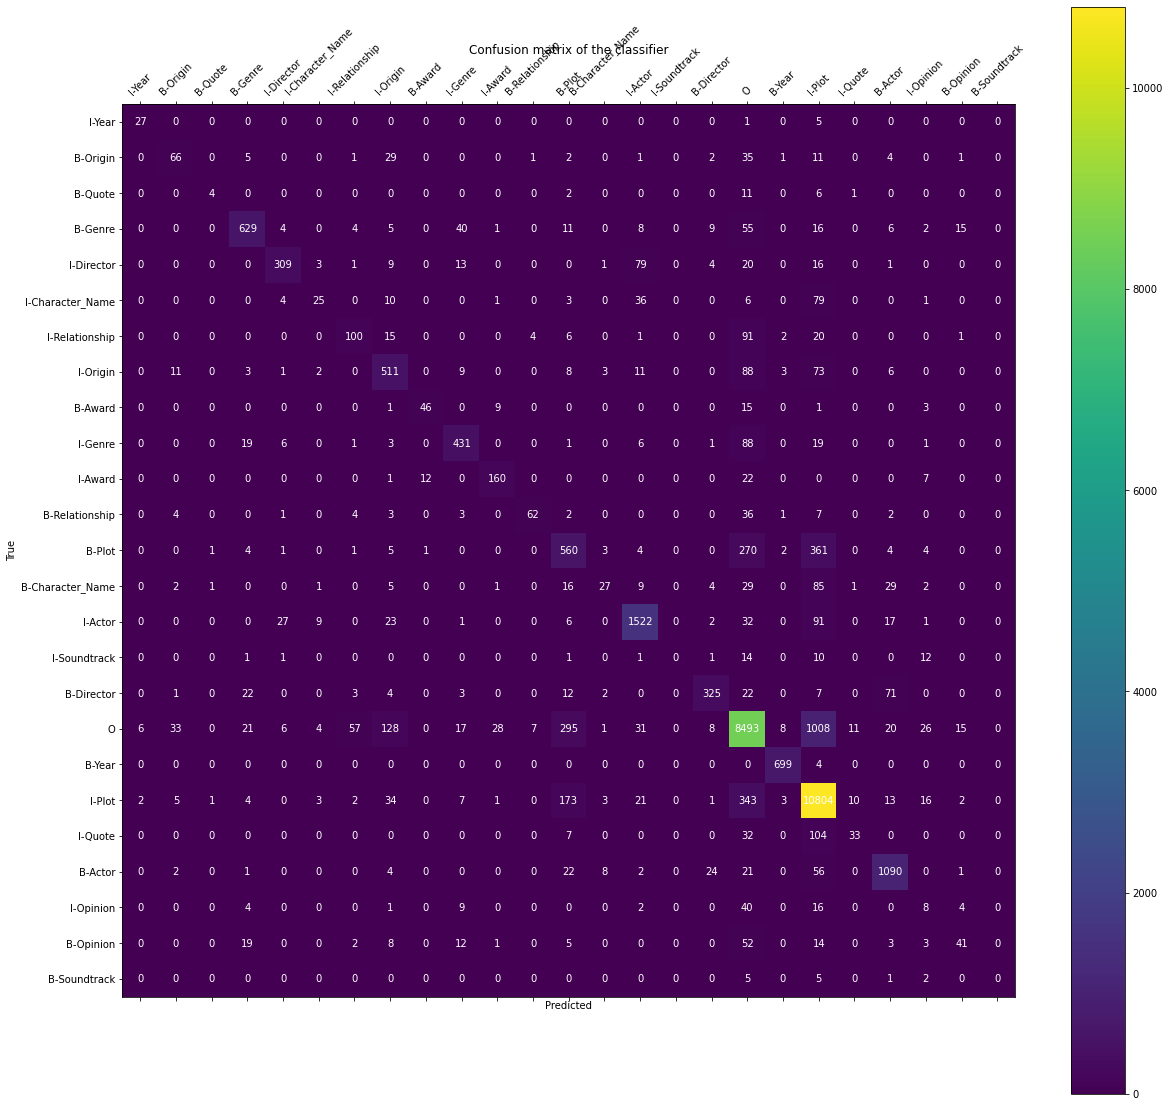

In [210]:
confusion_matrix_heatmap(y_test, preds)

# **5. Feature experimentation for optimal macro average**

# **modify the model on smaller scale data**

In [211]:
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

In [212]:
def preProcess(example):
    preprocessed_example = []
    actual_words = []    
    for example_words in example: 
        actual_words.append(example_words[0])
    POS_tagged_words = posttagger.tag(actual_words)     
    for i in range(len(POS_tagged_words)):
        str1 = ''
        str1 += POS_tagged_words[i][0] + '@' + POS_tagged_words[i][1]
        example_result = tuple([str1,example[i][1]])  
        preprocessed_example.append(example_result)
    return preprocessed_example

In [213]:
training_data_new = [preProcess(example) for example in training_data_train]
print(training_data_new[0])

[('steve@PRPVBP', 'B-Actor'), ('mcqueen@VBN', 'I-Actor'), ('provided@VBN', 'O'), ('a@DT', 'O'), ('thrilling@NN', 'B-Plot'), ('motorcycle@NN', 'I-Plot'), ('chase@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('this@DT', 'I-Plot'), ('greatest@JJS', 'B-Opinion'), ('of@IN', 'I-Opinion'), ('all@DT', 'I-Opinion'), ('ww@NNP', 'B-Plot'), ('2@NNP', 'I-Plot'), ('prison@NNP', 'I-Plot'), ('escape@NN', 'I-Plot'), ('movies@NNS', 'I-Plot')]


In [214]:
_pattern = re.compile(r"\d")

def get_features(tokens, idx):
    token = tokens[idx]
    feature_list = []
    POS_tagged_token = token.split('@')
    actual_word = POS_tagged_token[0]
    POS_tag = POS_tagged_token[1]
    if not token:
        return feature_list
    # Capitalization
    if actual_word[0].isupper():
        feature_list.append("CAPITALIZATION")
    #Number 
    if re.search(_pattern, actual_word) is not None:
        feature_list.append("HAS_NUM")
    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in actual_word):
        feature_list.append("PUNCTUATION")
    #Suffix up to length 3
    if len(actual_word) > 1:
        feature_list.append("SUF_" + actual_word[-1:])
    if len(actual_word) > 2:
        feature_list.append("SUF_" + actual_word[-2:])
    if len(actual_word) > 3:
        feature_list.append("SUF_" + actual_word[-3:])

#using more suffixes(Suffix up to length 5)
    if len(actual_word) > 4:
        feature_list.append("SUF_" + actual_word[-4:]) 
    if len(actual_word) > 5:
        feature_list.append("SUF_" + actual_word[-5:]) 

#using prefix(Prefix up to length 5)
    if len(actual_word) > 1:
        feature_list.append("PRE_" + actual_word[:1])
    if len(actual_word) > 2:
        feature_list.append("PRE_" + actual_word[:2])
    if len(actual_word) > 3:
        feature_list.append("PRE_" + actual_word[:3])
    if len(actual_word) > 4:
        feature_list.append("PRE_" + actual_word[:4])
    if len(actual_word) > 5:
        feature_list.append("PRE_" + actual_word[:5])

# next N token with its tag (N up to 3)
    if idx+1 < len(tokens):
        next_token = tokens[idx+1] 
        nex_tokens = next_token.split('@')
        next_word = nex_tokens[0]
        next_tag = nex_tokens[1]
        feature_list.append("NEXT_WORD_" + next_word)
        feature_list.append("NEXT_POS_" + next_tag)

    if idx+2 < len(tokens):
        next_token = tokens[idx+2] 
        nex_tokens = next_token.split('@')
        next_word = nex_tokens[0]
        next_tag = nex_tokens[1]
        feature_list.append("NEXT_WORD_" + next_word)
        feature_list.append("NEXT_POS_" + next_tag)

    if idx+3 < len(tokens):
        next_token = tokens[idx+3] 
        nex_tokens = next_token.split('@')
        next_word = nex_tokens[0]
        next_tag = nex_tokens[1]
        feature_list.append("NEXT_WORD_" + next_word)
        feature_list.append("NEXT_POS_" + next_tag)

# previous N token with its tag (N up to 3)
    if idx-1 >= 0:
        previous_token = tokens[idx-1] 
        prev_tokens = previous_token.split('@')
        prev_word = prev_tokens[0]
        prev_tag = prev_tokens[1]
        feature_list.append("PREV_WORD_" + prev_word)
        feature_list.append("PREV_TAG" + prev_tag) 

    if idx-2 >= 0:
        previous_token = tokens[idx-2] 
        prev_tokens = previous_token.split('@')
        prev_word = prev_tokens[0]
        prev_tag = prev_tokens[1]
        feature_list.append("PREV_WORD_" + prev_word)
        feature_list.append("PREV_TAG" + prev_tag)

    if idx-3 >= 0:
        previous_token = tokens[idx-3] 
        prev_tokens = previous_token.split('@')
        prev_word = prev_tokens[0]
        prev_tag = prev_tokens[1]
        feature_list.append("PREV_WORD_" + prev_word)
        feature_list.append("PREV_TAG" + prev_tag) 

# lowercase letters words as features
    feature_list.append("LOWERCASE_WORD_" + actual_word.lower())

    feature_list.append("WORD_" + actual_word)

    feature_list.append("POS_" + POS_tag)
    return feature_list


In [215]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data_new, TAGGER_PATH)
print("done")


training tagger...
done


In [216]:
develope_data_new = [preProcess(example) for example in training_data_develope]

In [217]:
print("testing tagger...")
preds = []
y_test = []
for sent in develope_data_new:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

print(classification_report(y_test, preds, zero_division=1))

testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.92      0.95      0.93      1231
         B-Award       0.78      0.71      0.74        75
B-Character_Name       0.74      0.39      0.51       212
      B-Director       0.92      0.80      0.86       472
         B-Genre       0.88      0.84      0.86       805
       B-Opinion       0.56      0.34      0.42       160
        B-Origin       0.54      0.43      0.48       159
          B-Plot       0.47      0.44      0.45      1221
         B-Quote       0.50      0.21      0.29        24
  B-Relationship       0.80      0.47      0.59       125
    B-Soundtrack       1.00      0.08      0.14        13
          B-Year       0.98      0.98      0.98       703
         I-Actor       0.92      0.96      0.94      1731
         I-Award       0.85      0.84      0.84       202
I-Character_Name       0.72      0.43      0.54       165
      I-Director       0.92      0.79      0.85 

In [218]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    print(cm)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

[[   21     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     6     0     6     0     0     0     0
      0]
 [    0    69     0     5     0     0     0    25     0     0     0     1
      5     0     1     0     2    38     1     9     0     1     0     2
      0]
 [    0     0     5     0     0     0     0     0     0     0     0     0
      4     0     0     0     0     7     0     7     1     0     0     0
      0]
 [    0     2     0   679     2     0     1     3     0    40     0     0
      9     0     4     0     8    31     0     6     0     1     5    14
      0]
 [    0     0     0     0   360     0     1     4     0    10     0     0
      0     0    47     0     2    27     0     3     0     2     0     0
      0]
 [    0     0     0     0     0    71     0     4     0     0     1     0
      1     0    16     0     0     5     0    65     0     2     0     0
      0]
 [    0     0     0     0     0     0   106     5     0   

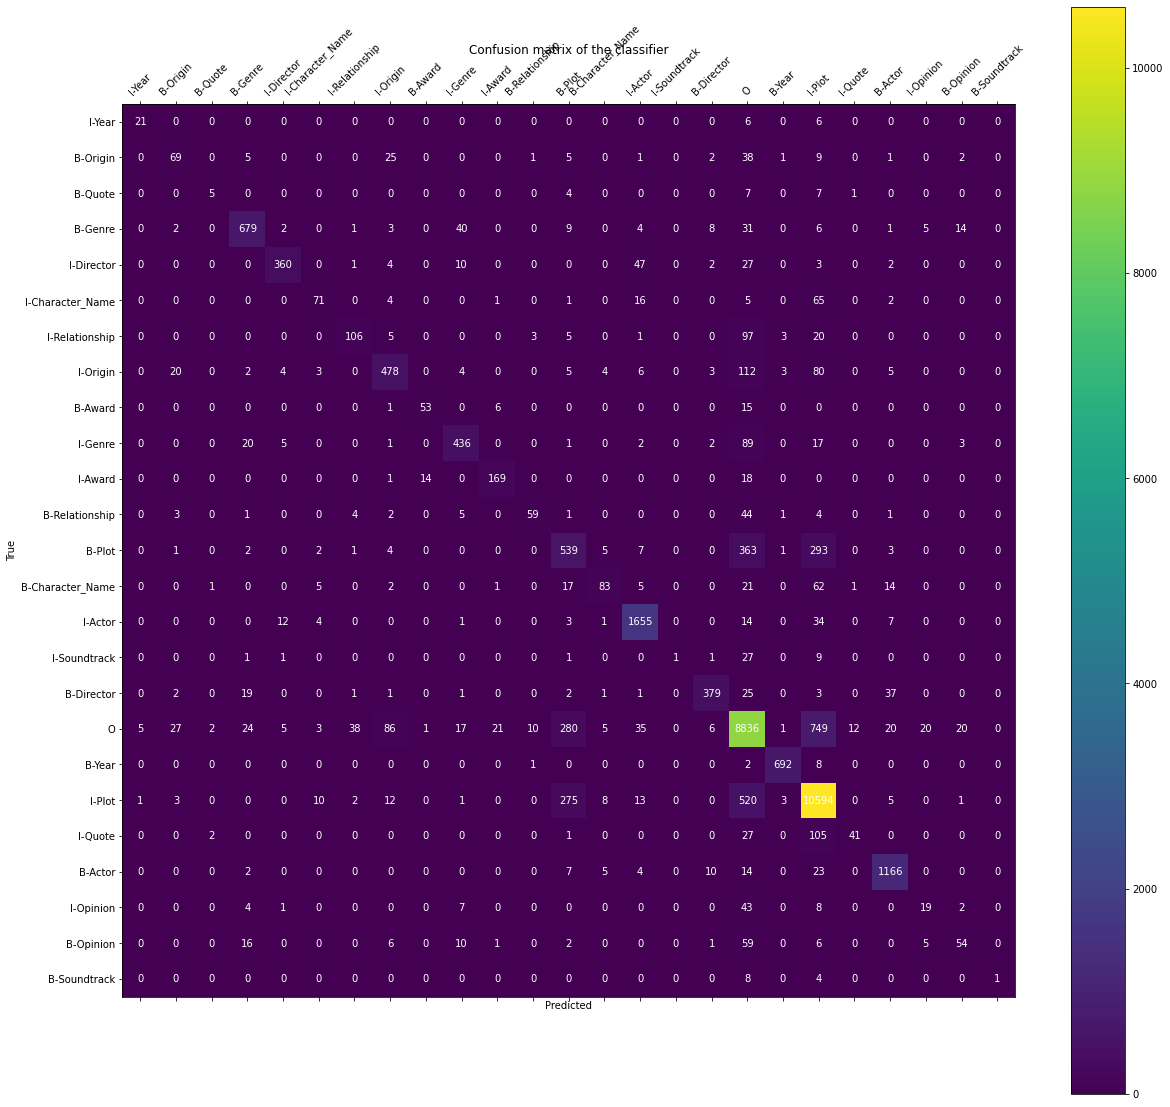

In [219]:
confusion_matrix_heatmap(y_test, preds)

original macro avg f-score： 0.55
Using POS tags as features(Q4): 0.56

after Suffix up to length 5
macro avg  f1-score：0.57

after using prefix(Prefix up to length 5)
macro avg  f1-score：0.60

after N token with its tag (N up to 3)
macro avg  f1-score：0.60 (No changes)

after N token with its tag (N up to 3)
macro avg  f1-score：0.62

after using lowercase words as features
macro avg  f1-score：0.62(no changes)

# **retrain the model on the full data**

In [220]:
training_data_full = [preProcess(example) for example in raw_training_data] # raw_train_data is the data set we import in Q1
print(training_data_full[0])

[('steve@PRPVBP', 'B-Actor'), ('mcqueen@VBN', 'I-Actor'), ('provided@VBN', 'O'), ('a@DT', 'O'), ('thrilling@NN', 'B-Plot'), ('motorcycle@NN', 'I-Plot'), ('chase@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('this@DT', 'I-Plot'), ('greatest@JJS', 'B-Opinion'), ('of@IN', 'I-Opinion'), ('all@DT', 'I-Opinion'), ('ww@NNP', 'B-Plot'), ('2@NNP', 'I-Plot'), ('prison@NNP', 'I-Plot'), ('escape@NN', 'I-Plot'), ('movies@NNS', 'I-Plot')]


In [221]:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 

In [222]:
test_data_full = [preProcess(example) for example in raw_test_data] 

In [223]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data_full, TAGGER_PATH)
print("done")

training tagger...
done


In [224]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data_full:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

print(classification_report(y_test, preds, zero_division=1))

testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1274
         B-Award       0.76      0.77      0.77        66
B-Character_Name       0.72      0.45      0.55       283
      B-Director       0.88      0.86      0.87       425
         B-Genre       0.81      0.81      0.81       789
       B-Opinion       0.47      0.35      0.40       195
        B-Origin       0.47      0.38      0.42       190
          B-Plot       0.50      0.49      0.50      1577
         B-Quote       0.90      0.38      0.54        47
  B-Relationship       0.76      0.57      0.65       171
    B-Soundtrack       1.00      0.12      0.22         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.91      0.94      0.93      1553
         I-Award       0.83      0.78      0.80       147
I-Character_Name       0.75      0.52      0.61       227
      I-Director       0.92      0.88      0.90 

macro avg f-score on full data set is 0.65

In [227]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    print(cm)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

[[   27     0     0     1     0     0     0     0     0     2     0     0
      0     0     0     0     0     7     2     5     0     0     0     0
      0]
 [    0    73     0     4     0     0    37     3     0     1     0     3
      6     0     0     0     3    46     1     9     0     3     0     1
      0]
 [    0     0    18     0     0     0     0     0     0     0     0     0
      3     0     1     0     0    15     0     8     2     0     0     0
      0]
 [    0     6     0   636     3     0     2     3     0    47     0     0
      4     0     1     0    15    45     0     4     0     0     2    21
      0]
 [    0     0     0     0   360     1     2     2     0     1     0     0
      0     0    28     0     1    12     0     4     0     0     0     0
      0]
 [    0     0     0     0     1   117     1     0     0     1     0     0
      0     6    33     0     0    13     0    51     1     3     0     0
      0]
 [    0    24     0     2     4     2   539    12     0   

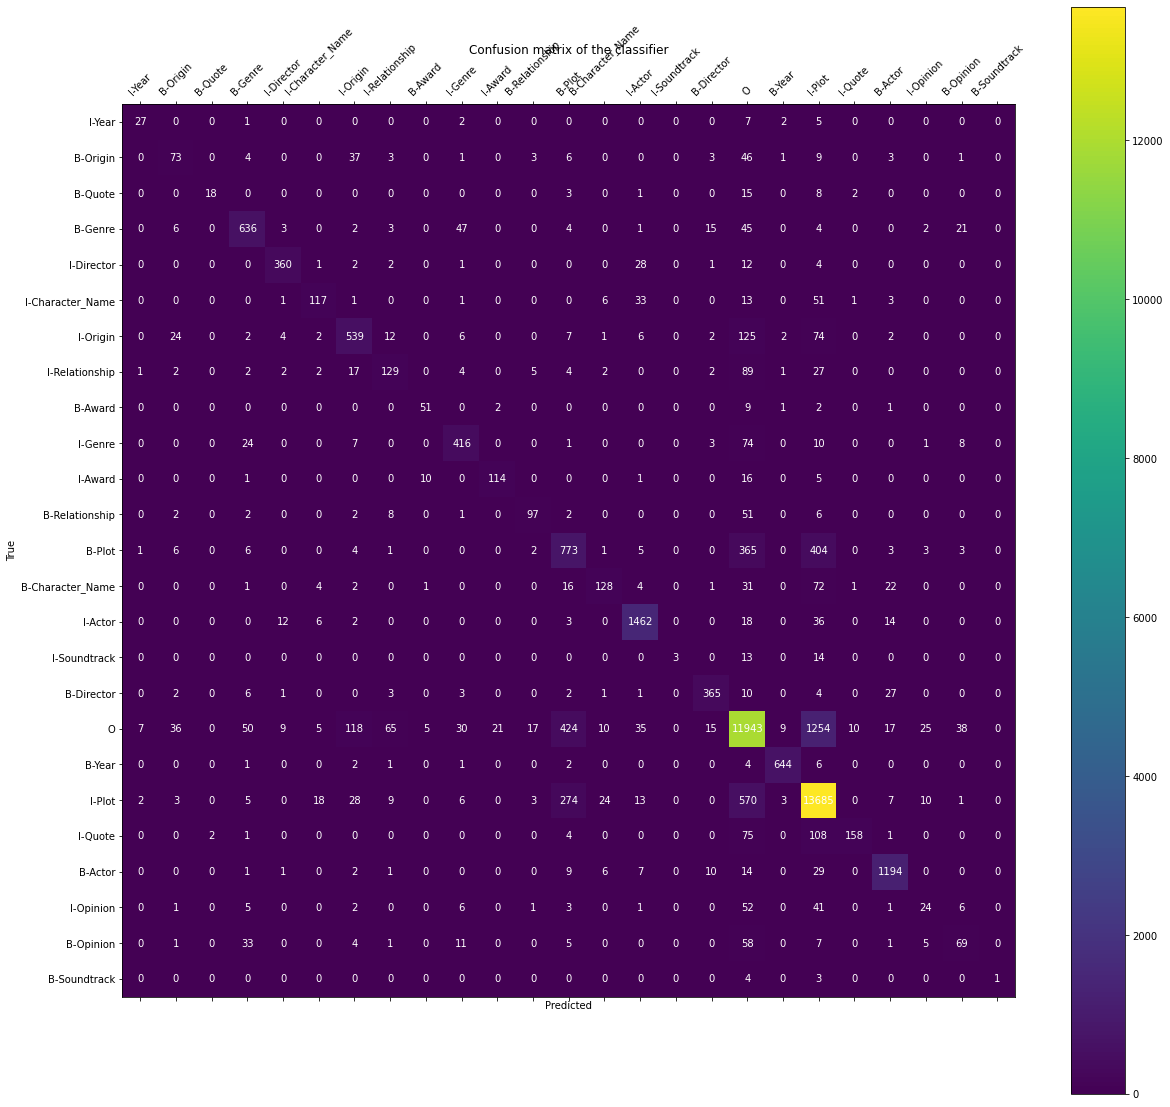

In [228]:
confusion_matrix_heatmap(y_test, preds)